In [3]:
import argparse
import copy
import math
import os
import random
import typing

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '..')

from dataset import get_dataloader, get_dataset
from EMA import WeightExponentialMovingAverage
from model import DeePMOS

In [4]:
data_path = '../../testVCC2/'
id_table = '../id_table/'
#train_set = get_dataset(data_path, "training_data.csv", vcc18=True, idtable=os.path.join(id_table, 'idtable.pkl'))
#valid_set = get_dataset(data_path, "valid_data.csv", vcc18=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))
test_set = get_dataset(data_path, "testing_data.csv", vcc18=True, valid=True, idtable=os.path.join(id_table, 'idtable.pkl'))

Loading all wav files.


100%|███████████████████████████████████████| 4000/4000 [01:24<00:00, 47.28it/s]
/Users/lxy/Desktop/DeePMOS/model_test/../dataset.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.scores['JUDGE'][i] = self.idtable[judge_i]


In [5]:
#train_loader = get_dataloader(train_set, batch_size=32, num_workers=1)
#valid_loader = get_dataloader(valid_set, batch_size=2, num_workers=1)
test_loader = get_dataloader(test_set, batch_size=4, num_workers=1)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = DeePMOS().to(device)

In [10]:
model = torch.load('../trained_models/best.pt',map_location=torch.device('cpu'))

AttributeError: Can't get attribute 'ProMOSNet' on <module 'model' from '/Users/lxy/Desktop/DeePMOS/model_test/../model.py'>

In [15]:
wavs, filename, _, mos, _ = next(iter(test_loader))
wavs = wavs.to(device)
wavs = wavs.unsqueeze(1)
mos = mos.to(device)

In [16]:
mos_mean, mos_var = model(speech_spectrum=wavs) # (batch, seq_len, 1), (batch, seq_len, 1)
mos_mean = mos_mean.squeeze(-1) # shape (batch, seq_len)
mos_var = mos_var.squeeze(-1) # shape (batch, seq_len)
mos_mean = torch.mean(mos_mean, dim = -1) # torch.Size([1])
mos_var = torch.mean(mos_var, dim = -1) # torch.Size([1])
'''
mos_mean = mos_mean.squeeze() # (batch, seq_len)
mos_var = mos_var.squeeze() # (batch, seq_len)
seq_len = mos_mean.shape[1]
bsz = mos_mean.shape[0]
mos = mos.unsqueeze(1).repeat(1, seq_len) # (batch, seq_len) by repeat seq_len times
'''

'\nmos_mean = mos_mean.squeeze() # (batch, seq_len)\nmos_var = mos_var.squeeze() # (batch, seq_len)\nseq_len = mos_mean.shape[1]\nbsz = mos_mean.shape[0]\nmos = mos.unsqueeze(1).repeat(1, seq_len) # (batch, seq_len) by repeat seq_len times\n'

In [20]:
mos = mos.cpu().detach().numpy().tolist()
mos_mean = mos_mean.cpu().detach().numpy().tolist()
mos_var = mos_var.cpu().detach().numpy().tolist()

In [12]:
criterion = F.gaussian_nll_loss
loss = criterion(mos_mean, mos, mos_var) # torch.Size([])
loss

In [28]:
mos_means = []
mos_vars = []
mos_s = []
for i, batch in enumerate(tqdm(test_loader, ncols=0, unit=" step")):
    wav, filename, _, mos, _ = batch
    wav = wav.to(device)
    wav = wav.unsqueeze(1) # shape (batch, 1, seq_len, 257)
    mos = mos.to(device)

    with torch.no_grad():
        mos_mean, mos_var = model(speech_spectrum = wav) # shape (batch, seq_len, 1)
        mos_mean = mos_mean.squeeze(-1) # shape (batch, seq_len)
        mos_var = mos_var.squeeze(-1) # shape (batch, seq_len)
        mos_mean = torch.mean(mos_mean, dim = -1) # torch.Size([1])
        mos_var = torch.mean(mos_var, dim = -1) # torch.Size([1])
        
        mos_s.extend(mos.cpu().detach().numpy().tolist())
        mos_means.extend(mos_mean.cpu().detach().numpy().tolist())
        mos_vars.extend(mos_var.cpu().detach().numpy().tolist())

100% 1000/1000 [06:42<00:00,  2.49 step/s]


In [7]:
import scipy.stats as stats
from scipy.stats import gmean
LH = []
for i in range(len(mos_s)):
    LH.append(stats.norm.pdf(mos_s[i], mos_means[i], math.sqrt(mos_vars[i])))

In [61]:
q1,q2,q3 = np.percentile(mos_s, [25, 50, 75])
print("First quantile {}, second quantile {}, third quantile {}".format(q1,q2,q3))

First quantile 2.25, second quantile 3.0, third quantile 3.5


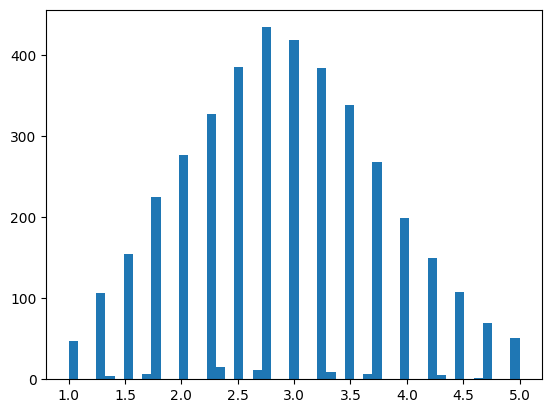

In [14]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=mos_s, bins=np.linspace(1,5,50))
plt.savefig("MOS_dis.png")

In [38]:
np.mean(mos_s)

2.9015208333432674

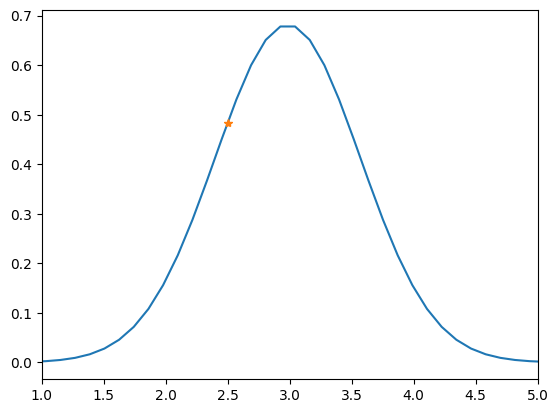

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

idx = 10
mos_v = mos_s[idx]
mu = mos_means[idx]
variance = mos_vars[idx]
sigma = math.sqrt(variance)
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.plot(mos_v, stats.norm.pdf(mos_v, mu, sigma), '*')
plt.xlim([1, 5])
plt.savefig("dist_test"+str(idx)+".png")
plt.show()

In [59]:
mu

2.9838850498199463

In [60]:
np.sqrt(variance)

0.5853354094462336

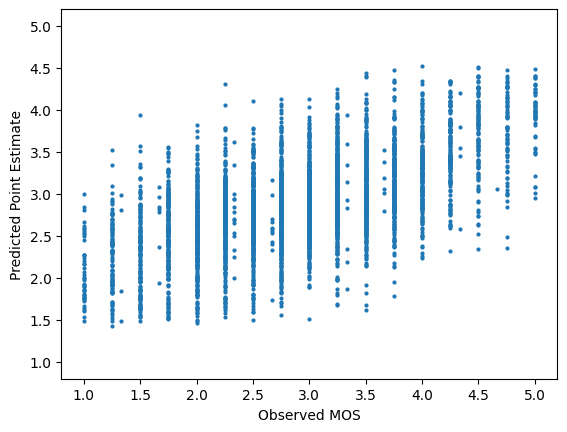

In [68]:
plt.scatter(mos_s, mos_means,s=4)
plt.xlim([0.8,5.2])
plt.ylim([0.8,5.2])
plt.xlabel("Observed MOS")
plt.ylabel("Predicted Point Estimate")
plt.savefig("MOS_scatter.png")

In [32]:
len(mos_means)

4000

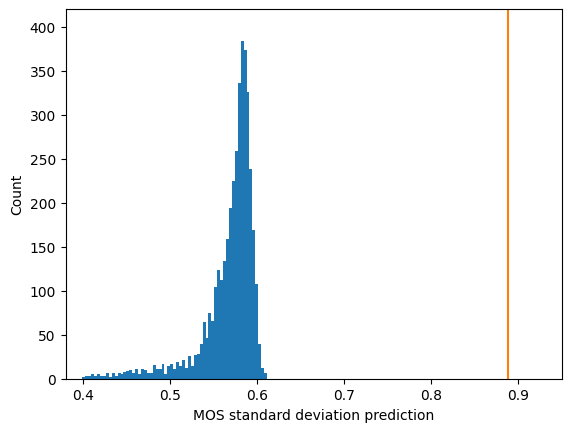

In [67]:
n, bins, patches = plt.hist(x=np.sqrt(mos_vars), bins="auto")
plt.xlim([0.38, 0.95])
plt.ylim([0,420])
plt.xlabel("MOS standard deviation prediction")
plt.ylabel("Count")
plt.plot([0.888]*420, list(range(0,420)))
plt.savefig("MOS_sd_hist.png")

In [40]:
np.mean(np.sqrt(mos_vars))

0.5677147824525767

In [41]:
np.std(np.sqrt(mos_vars))

0.032229362378608295